# WDM simulation

## Transmitter

In [32]:
from optical_flax.fiber_system import Tx_data, channel, Rx_data
import jax
import jax.random as rd

In [40]:
key = rd.PRNGKey(123)
batch = 1
sigWDM, symbWDM, param = Tx_data(key, batch, Nch=11, Power=0, SpS=16, Nbits=40000)

Sample rate fa: 5.76e+11, Cut off frequency fc: 2.75e+11, fa > 2fc: True
Transmitter is working..
signal shape: (160000, 2), symb shape: (10000, 11, 2)
 Tx_data complete, time cost(s):2.1982429027557373


In [45]:
symbWDM.ndim

3

## Channel

In [41]:
Fs = param.Rs*param.SpS  # sample rates
key = rd.PRNGKey(134)
sigWDM_rx, paramCh = channel(key,sigWDM, Fs)

data transmition...
channel transmission done!
Signal shape (160000, 2)
 channel complete, time cost(s):1.8491175174713135


## Receiver

In [42]:
key = rd.PRNGKey(234)
rx_sps = 8
data_sml, paramRx, noise = Rx_data(key, sigWDM_rx, symbWDM, rx_sps, param=param, paramCh=paramCh)

 Rx_data complete, time cost(s):9.163892269134521


In [44]:
data_sml.x.shape

(10000, 11)

## CDC 实现对比

In [10]:
## CDC 实现对比
from optical_flax.layers import fdbp
from commplax.module import core
import jax.random as random
from optical_flax.initializers import fdbp_init
from optical_flax.dsp import firFilter, edc, fourthPowerFOE, dbp, cpr2, downsampling, simple_cpr, test_result

d_init, n_init = fdbp_init(data_sml.a, xi=0.0, steps=1, domain='time')
cdc = fdbp(steps = 1, dtaps=2001, ntaps=1, d_init=d_init, n_init=n_init)
key = random.PRNGKey(0)
cdc_param = cdc.init(key, core.Signal(data_sml.y))
y = cdc.apply(cdc_param, core.Signal(data_sml.y))


y1,H = edc(data_sml.y, paramCh.Ltotal, paramCh.D, param.Fc - paramRx.freq, param.Rs * paramRx.sps)
from optical_flax.utils import MSE
print(MSE(y.val,y1[y.t.start:y.t.stop])/MSE(y.val,0))

0.001432005


# Experiments

In [1]:
import jax
import jax.numpy as jnp
from jax import device_put, device_get
import jax.random as random
import numpy as np
import flax.linen as nn
import optax
from functools import partial, wraps
from typing import Any, NamedTuple,Callable, Iterable, Optional, Tuple, Union,Sequence
from optical_flax.utils import realize, normal_init, show_tree, tree_r2c, tree_c2r
from collections import namedtuple
from flax.core import freeze, unfreeze
from commplax.module import core
from commplax.module.core import SigTime, Signal, zeros, conv1d_t, vmap,wpartial,delta,gauss
import optical_flax.base as base
import optical_flax.layers as layers
import optax
import matplotlib.pyplot as plt
## Define datax
from gdbp import gdbp_base as gb, data as gdat, aux
data_train = gdat.load(1, 0, 4, 2)[0]
data_test = gdat.load(2, 0, 4, 2)[0]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

loading data:   0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
data_train.a

{'baudrate': 36000000000.0,
 'channelindex': 4,
 'channels': 7,
 'distance': 1125000.0,
 'lpdbm': 0.0,
 'lpw': 0.001,
 'modformat': '16QAM',
 'polmux': 1,
 'samplerate': 72000000000.0,
 'spans': 15,
 'srcid': 'src1',
 'CD': 18.451}

## 1.FDBP Model

In [4]:
## Training FDBP Model on a signal 
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [2e-5, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)

## define model
batch_size = 500
sparams_flatkeys = []  # [('FDBP',),('RConv',)]
model = base.model_init(data_train,sparams_flatkeys=sparams_flatkeys)  
gen = base.train(model, data_train, batch_size=500, n_iter=2000, tx=tx)
loss0, Train0 = base.run_result(gen)

training:   0%|          | 0/2000 [00:00<?, ?it/s]

/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '


## 2.Meta-DBP Model

In [ ]:
## Meta DBP :
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [2e-5, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)
sparams_flatkeys =   [] # [('DBP',),('RConv',)]
model = base.model_init(data_train,init_len = 1990, sparams_flatkeys=sparams_flatkeys,domain='frequency',GDBP=MetaSSFM, dtaps=1990, ntaps=1)  
gen = base.train(model, data_train, batch_size=500, n_iter=2000, tx=tx)
loss1, Train1 = base.run_result(gen)

## 3.GRU-DBP

In [ ]:
## GRU DBP : 输入的Batch size 需要调整
from optical_flax.layers import MetaSSFM, GRU_DBP, fdbp
from commplax import optim 
lr = optim.piecewise_constant([500, 1000], [2e-5, 1e-5, 1e-6])
tx = optax.adam(learning_rate=lr)
sparams_flatkeys = []  # [('FDBP',),('RConv',)]
model = base.model_init(data_train,init_len = 2000, sparams_flatkeys=sparams_flatkeys,domain='time',GDBP=GRU_DBP ,dtaps=261, n_taps=1)  
gen = base.train(model, data_train, batch_size=500, n_iter=10, tx=tx)
loss2, Train2 = base.run_result(gen)

In [ ]:
### 可视化阶段性结果
import optical_flax.layers as layers
from commplax import plot as cplt

fdbp = realize(layers.fdbp())
params = Train1[-1].params['DBP']
y = core.Signal(data_train.y[1000:2990])

key = random.PRNGKey(0)
init_p = fdbp.init(key, y)
z = fdbp.apply({'const':init_p['const'], 'params':params}, y)

cplt.scatter(y.val)
cplt.scatter(z.val)

# Signal Processing

## 1.Dispersion operator

DeviceArray(0.07536945, dtype=float32)

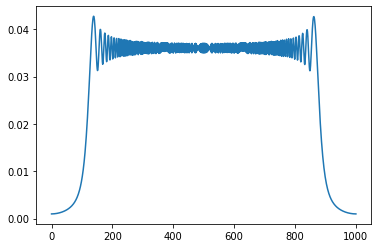

In [5]:
## Data Loading test
import matplotlib.pyplot as plt
n_batch, batch_gen = gb.get_train_batch(data_train, batchsize=500, overlaps=model.overlaps,sps=2) 
for (y, x) in batch_gen:
    break

## dbp_params  Time domian dispersion kernel
from commplax import comm
a = data_train.a
h,phi = comm.dbp_params(a['samplerate'], a['distance'] / a['spans'],a['spans'], 1001,
            a['lpdbm'] - 3, 
            virtual_spans=1,
            ignore_beta3=False)

ifft = jnp.fft.ifft
fft = jnp.fft.fft
h0 = h[0,:,1]
plt.plot(jnp.abs(h0))


from optical_flax.initializers import fdbp_init
d_init, n_init = fdbp_init(data_train.a, steps=3)
key = random.PRNGKey(0)
jnp.sum(n_init(key, (3,)))

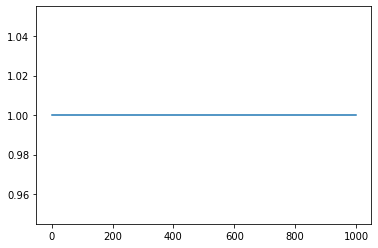

In [6]:
from optical_flax.dsp import linFiberCh
linearChannel = False
paramCh = parameters()
paramCh.D = 16.5       # ps/nm/km
paramCh.Fc = 193.4e12  # Hz
paramCh.hz =  10      # km
paramCh.gamma = 1.3174420805376552    # 1/(W.km)
paramCh.amp = 'edfa'
_,H = linFiberCh(np.zeros(1001), a['distance'], 0, paramCh.D, paramCh.Fc, a['samplerate']/1e3)
plt.plot(np.abs(ifft(H)))


## 2.Basics

In [1]:
## 信号处理基础
fft = np.fft.fft
ifft = np.fft.ifft
shift = np.fft.fftshift
freq = np.fft.fftfreq

NameError: name 'np' is not defined

In [ ]:
def circ_conv(x,y):
    '''
    使用fft实现周期卷积
    '''
    return ifft(fft(x)*fft(y))

def full_conv(x,y):
    ''' 
    使用周期卷积实现全卷积
    '''
    L = len(x) + len(y) - 1
    x_pad = jnp.concatenate([x,np.zeros(L-len(x))])
    y_pad = jnp.concatenate([y,np.zeros(L-len(y))])
    return circ_conv(x_pad,y_pad)

def circ_conv2(x,y):
    '''
    使用全卷积实现周期卷积
    '''
    N = x.shape[0]
    return jnp.convolve(x,y)[0:N] + jnp.concatenate([jnp.convolve(x,y)[N:2*N-1],jnp.zeros(1)])


def c_conv(x,h):
    ''' 
    周期边界
    '''
    k = h.shape[0]//2
    N = x.shape[0]
    y = jnp.convolve(x,h)
    z = y[k:k + N]
    z = z.at[0:k].add(y[-k:])
    z = z.at[-k:].add(y[0:k])
    return z

In [ ]:
net = nn.Conv(features=1,kernel_size=(3,),strides=(1,),padding='same')
x = rd.normal(rd.PRNGKey(0),(10,1))
y,p = net.init_with_output(rd.PRNGKey(0), x)
x = jnp.squeeze(x)
h = jnp.squeeze(p['params']['kernel'])
jnp.correlate(x,h,'same') - jnp.squeeze(y)

2.454751086441367e-12


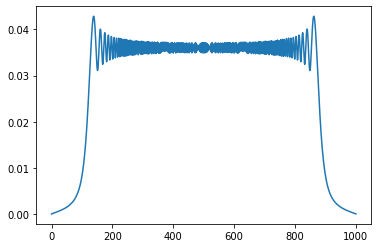

In [10]:
## dispersion operator
N = 1001
h = 1/a['samplerate']
w = 2 * np.pi *np.fft.fftfreq(N, h) # ifftshifted  w的范围不会随着 N 改变

B_2   = -2.1044895291667397e-26
dz = 375000.0*3
C = B_2 / 2 * dz 
H   = np.exp(-1j * C * w**2)

delay   = (N - 1) // 2
H_casual = H * np.exp(-1j * w * delay * h) ## 频域相位旋转等价于时域平移，将时域对齐
h_casual = ifft(H_casual)
h1 = shift(ifft(H))

plt.plot(np.abs(h1))
print(np.sum(np.abs(h1-h_casual)))

In [11]:
import scipy.constants as const
N = 1001
D =  paramCh.D
Fc = paramCh.Fc
Fs = a['samplerate']
alpha = 0
L = a['distance']/1e3
c_kms = const.c/1e3
λ  = c_kms/Fc
α  = alpha/(10*np.log10(np.exp(1)))
beta2 = -(D*λ**2)/(2*np.pi*c_kms)

omega = 2*np.pi*Fs * freq(N)
H1 = np.exp(-α*L - 1j*(beta2/2)*(omega**2)*L)


/home/xiaoxinyu/.conda/envs/commplax/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


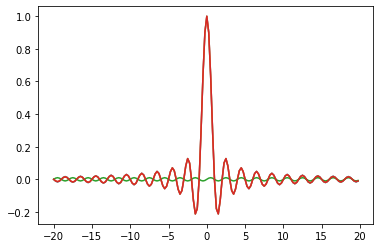

In [12]:
### FFT 做频谱分析
N = 400
h = 0.01
t = np.linspace(-0.5 * N*h,0.5*N*h,N)
x = (np.abs(t) < 0.5)*1.0
f = freq(N, h)
omega = 2*np.pi*f
xf = fft(shift(x))*h   # 使用fft计算离散信号的频谱 (需要shift 因为fft默认信号时间从0开始)

fs = shift(f)
xfs = shift(xf)

d = int(0.5*N- 20 * N * h)   ## 展示 【-20,20】Hz
plt.plot(fs[d:-d],np.sinc(fs)[d:-d])
plt.plot(fs[d:-d],xfs[d:-d])
plt.plot(fs[d:-d],xfs.imag[d:-d])
plt.plot(fs[d:-d],xfs.real[d:-d])

## 3.Spectral Method

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft,fftshift,ifft
from functools import partial
def get_frequency(N):
    k = np.arange(0,2*N) - N 
    k = fftshift(k)
    k[N] = 0  
    return k

def L(u,pde='kdv',N=128):
    # 构造频率向量
    k = get_frequency(N)
    
    # 构造离散谱算子
    if pde=='burgers':
        '''
        3(u^2)_x
        '''
        return -ifft(1j*k*fft(3*u*u))
    elif pde=='kdv':
        return -ifft((1j*k)**2*fft(u))
    elif pde == 'heat':
        return ifft((1j*k)**2 * fft(u))

def ode_solver(u0,L,dt,T,N):
    u = u0
    steps = int(T/dt)
    u_path = []
    for i in range(steps):
        u_path.append(u)
        u1 = u + dt*L(u,N=N)
        u2 = 3/4*u + 1/4*u1 + 1/4*dt*L(u1,N=N)
        u = 1/3*u + 2/3*u2 + 2/3*dt*L(u2,N=N)
    return u,u_path

def ode_1(u0,L,dt,T,N):
    u = u0
    steps = int(T/dt)
    u_path = []
    for i in range(steps):
        u_path.append(u)
        u = u + dt*L(u,N=N)
    return u,u_path

### 1.Convection equation

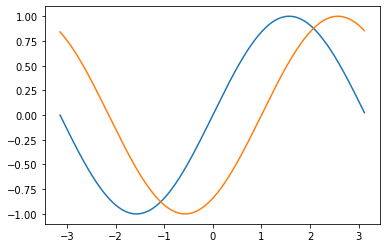

In [28]:
# 求解对流方程
'''
v_t + v_x = 0
'''
N = 128
T = 1
k = get_frequency(N)
x = np.linspace(-np.pi,np.pi,2*N,endpoint=False)
v = np.sin(x)
v_sol = ifft(np.exp(-1j*k*T)*fft(v))
plt.plot(x,v.real)
plt.plot(x,v_sol.real)

### 2.Burgers  equation

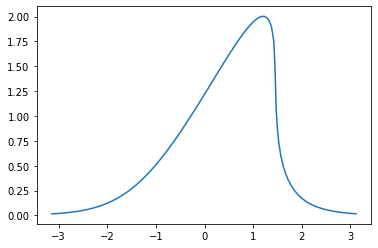

In [30]:
# 求解 burgers equation
'''
u_t + u u_x = 0
'''
N = 128
dt = 0.0001
T = 0.1
L0 = partial(L, pde='burgers')
x = np.linspace(-np.pi,np.pi,N*2,endpoint=False)
u0 = 2 / np.cosh(x)**2
u_sol,u_path = ode_1(u0,L0,dt,T,N=N)
plt.plot(x,u_sol.real)

### 3.kdv equation

In [17]:
# 求解 kdv 方程
M = 2.5
N = 128
dt = 0.0001
T = 3
x = np.linspace(-10,10,N*2,endpoint=False)
L = 10/np.pi
u0 = M*(M+1)/(np.cosh(x)**2) #+ np.random.rand(u0.size)*0.1
# u0 = (x > 0) * (x < 1)

u_tilde0 = fft(u0)
k = get_frequency(N) / L
def g(t):
    return np.exp(-1j*k**3*t)

def L_kdv(u_tilde,t):
    gt = g(t)
    return -3j * k * gt * fft(ifft(1/gt * u_tilde)**2)

def ode_solver(u0,L,dt,T):
    u = u0
    u_path = []
    t = 0
    while t < T:
        u_path.append({'t':t, 'data':u})
        u1 = u + dt*L(u,t)
        u2 = 3/4*u + 1/4*u1 + 1/4*dt*L(u1,t)
        u = 1/3*u + 2/3*u2 + 2/3*dt*L(u2,t)
        t = t + dt
    u_path.append({'t':t, 'data':u})
    return u,u_path

def transform(v_path):
    u_path = []
    for item in v_path:
        t = item['t']
        v = item['data']
        gt = g(t)
        u = ifft(1/gt * v)
        u_path.append({'t':t,'data':u})
    return u,u_path

v,v_path = ode_solver(u_tilde0, L_kdv, dt, T)
u,u_path = transform(v_path)

def solution(t):
    n = int(t/dt)
    return u_path[n]['data'].real

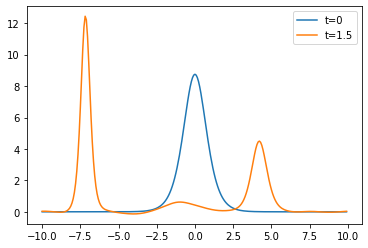

In [18]:
# 绘制静态图
plt.plot(x, solution(0),label='t=0')
plt.plot(x, solution(0.5), label='t=1.5')
plt.legend(loc='best')

### 4.diffusion equation

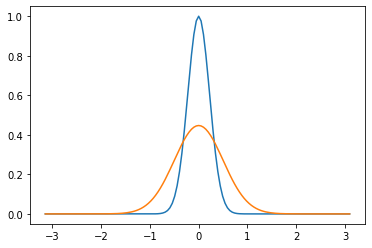

In [31]:
# 求解扩散方程
'''
u_t = u_xx
'''
N = 64
T = 0.1
k = get_frequency(N)
x = np.linspace(-np.pi,np.pi,2*N,endpoint=False)
v = np.exp(-10*x**2)
v_sol = ifft(np.exp(-(k**2)*T)*fft(v))
plt.plot(x,v.real)
plt.plot(x,v_sol.real)

### 5.dispersion equation

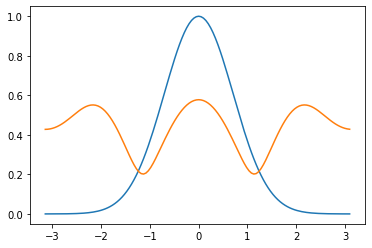

In [23]:
# 求解色散方程
'''
u_t = i u_xx
'''
N = 64
T = 10
k = get_frequency(N)
x = np.linspace(-np.pi,np.pi,2*N,endpoint=False)
v = np.exp(-x**2)
v_sol = ifft(np.exp(-0.2j*(k**2)*T)*fft(v))
v_sol_abs = np.abs(v_sol)

plt.plot(x,np.abs(v))
plt.plot(x,v_sol_abs)
